#Se monta el drive con los datos


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


#Instalación Keras-unet y RAdam


In [2]:
pip install git+https://github.com/karolzak/keras-unet

  Cloning https://github.com/karolzak/keras-unet to /tmp/pip-req-build-dmdp89bx
  Running command git clone -q https://github.com/karolzak/keras-unet /tmp/pip-req-build-dmdp89bx
  Created wheel for keras-unet: filename=keras_unet-0.0.7-cp36-none-any.whl size=11848 sha256=ccbc96861026638b697138ca32253ee650f650d04ffc930ba6952110b55e39fc
  Stored in directory: /tmp/pip-ephem-wheel-cache-hbiysle5/wheels/b3/3a/85/c3df1c96b5d83dcd2c09b634e72a98cafcf12a52501ac5cd77
Successfully built keras-unet


In [3]:
pip install keras-rectified-adam

  Created wheel for keras-rectified-adam: filename=keras_rectified_adam-0.17.0-cp36-none-any.whl size=14781 sha256=433b24cb07e08d98aa5176f3b9de22bcc00e69a8a1baf8d8dc98b104defee26c
  Stored in directory: /root/.cache/pip/wheels/7b/01/27/3a934e1a5644f5b93c720422a6ef97034ea78a21ba71cfb549
Successfully built keras-rectified-adam


In [0]:
from keras.callbacks import ModelCheckpoint, TensorBoard, EarlyStopping, ReduceLROnPlateau
from keras_unet.utils import get_augmented
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
import tensorflow as tf
import keras as K
import numpy as np
from keras_radam import RAdam

# Scripts en el github

In [0]:
from VGG16_UNET import UNET1_VGG16
from utils import extract_statistics


In [0]:
config = tf.ConfigProto( device_count = {'GPU': 56 , 'CPU': 56} ) 
sess = tf.Session(config=config) 
K.backend.set_session(sess)

#Se crea la red

In [7]:
model = UNET1_VGG16(keep_prob=0.3,optimizer=RAdam())





58892288/58889256 [==============================] - 3s 0us/step







Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 1)  0                                            
__________________________________________________________________________________________________
gray_to_rgb (Gray2VGGInput)     (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 256, 256, 64) 1792        gray_to_rgb[0][0]                
__________________________________________________________________________________________________


# Carga de datos

In [0]:
directory= '/content/drive/My Drive/myocardium-segmentation/'

In [0]:
X_test=np.load( directory + 'test_imgs.npy')
y_test=np.load( directory + 'test_annot.npy')

X_train=np.load( directory + 'train_imgs.npy')
y_train=np.load( directory + 'train_annot.npy')

X_val=np.load( directory + 'val_imgs.npy')
y_val=np.load( directory + 'val_annot.npy')

In [0]:
X_test = X_test.reshape(1240,256,256,1)
y_test = y_test.reshape(1240,256,256,1)

X_train = X_train.reshape(4564,256,256,1)
y_train = y_train.reshape(4564,256,256,1)

X_val = X_val.reshape(502,256,256,1)
y_val = y_val.reshape(502,256,256,1)

In [0]:
y_test = to_categorical(y_test,num_classes=3)
y_train = to_categorical(y_train,num_classes=3)
y_val = to_categorical(y_val,num_classes=3)


#Callbacks



In [0]:
LOG_DIR = 'logs'
model_filename = 'model_example.h5'
callback_checkpoint = ModelCheckpoint(
    directory+'results/models/'+model_filename, 
    verbose=1, 
    monitor='val_loss', 
    save_best_only=True,
)

tensorboard_callback = TensorBoard(log_dir=LOG_DIR)
reduce_learning_rate = ReduceLROnPlateau(monitor='loss', factor=0.75, patience=1, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


#Data Augmentation

In [0]:
batch_size = 24
train_gen = get_augmented(
    X_train, y_train, batch_size=batch_size,
    data_gen_args = dict(
        rotation_range=15.,
        width_shift_range=0,
        height_shift_range=0,
        shear_range=0,
        zoom_range=0.2,
        horizontal_flip=True,
        vertical_flip=True,
        fill_mode='constant'
    ))


#Train

In [16]:
epochs=100
steps_per_epoch = X_train.shape[0]/batch_size
result = model.fit_generator(train_gen, epochs=epochs, steps_per_epoch=steps_per_epoch,
                                     validation_data=(X_val, y_val),
                                     callbacks=[callback_checkpoint, tensorboard_callback, early_stopping])

Epoch 1/100
191/190 [==============================] - 299s 2s/step - loss: 0.8548 - per_class_iou: 0.1911 - val_loss: 0.4294 - val_per_class_iou: 0.2791

Epoch 00001: val_loss improved from inf to 0.42945, saving model to /content/drive/My Drive/myocardium-segmentation/results/models/dropout03

Epoch 2/100
191/190 [==============================] - 286s 1s/step - loss: 0.3726 - per_class_iou: 0.2953 - val_loss: 0.1540 - val_per_class_iou: 0.4085

Epoch 00002: val_loss improved from 0.42945 to 0.15404, saving model to /content/drive/My Drive/myocardium-segmentation/results/models/dropout03
Epoch 3/100
191/190 [==============================] - 286s 1s/step - loss: 0.1584 - per_class_iou: 0.4314 - val_loss: 0.0820 - val_per_class_iou: 0.5551

Epoch 00003: val_loss improved from 0.15404 to 0.08201, saving model to /content/drive/My Drive/myocardium-segmentation/results/models/dropout03
Epoch 4/100
191/190 [==============================] - 286s 1s/step - loss: 0.1281 - per_class_iou: 0.4

#Evaluación

In [0]:
ypred= model.predict(X_test)

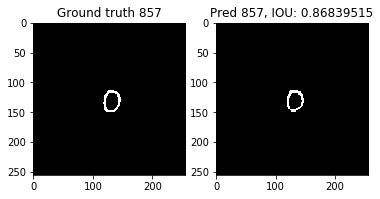

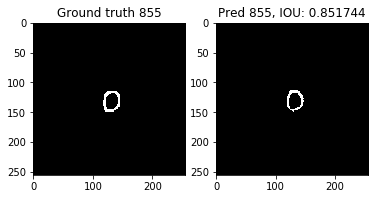

USING <function np_iou at 0x7f21e94468c8>
For class 0: 0.9969608049089648+-0.0018785406816838298
For class 1: 0.6767867521542135+-0.13995426640132952
For class 2: 0.8164576566879113+-0.16415138207231766
Mean and std of scores per class: 0.8300684045836966
Global IoU: 0.9912277348419032 +/- 0.004489014319401177
------------------------------
USING <function np_dice_coef at 0x7f21e9446ae8>
For class 0: 0.9984771881641147+-0.0009458114349474926
For class 1: 0.7960837650524574+-0.134201428480582
For class 2: 0.8850424226311696+-0.15200415140756512
Mean and std of scores per class: 0.8932011252825806
Global IoU: 0.9955893739010596 +/- 0.0022786978246340846
------------------------------
USING <function np_iou_thresholded at 0x7f21e9446b70>
For class 0: 0.9969608049089648+-0.0018785406816838298
For class 1: 0.6767867521542135+-0.13995426640132952
For class 2: 0.8164576566879113+-0.16415138207231766
Mean and std of scores per class: 0.8300684045836966
Global IoU: 0.9912277348419032 +/- 0.0044

In [42]:
extract_statistics(y_test,ypred,plot_examples=True)